I explore style transfer in [this notebook](https://www.kaggle.com/pradhyo/keras-style-transfer?scriptVersionId=9461535) using deep learning. This is one of my favorite applications of deep learning - this was interesting at first because the output is so visual and then even more after learning the technique. Here are some output images.

![](output/maldives_wave_at_iteration_49.png)
![](output/sf_afremo_rain_at_iteration_0.png)
![](output/nyc2_mosaic_at_iteration_49.png)
![](output/nyc_udnie_at_iteration_0.png)

The goal is to take two images, one with a distinct "style" and another with the desired "content" and combine so the style of the first image is transferred to the latter.
The way this approach of style transfer works is just like most deep learning approaches - specify a loss function and use a neural network to reduce this loss function. In this case, the loss comprises two major parts, 
1. Style loss - by minimizing this, the neural net learns to get closer to the style. 
2. Content loss - this loss ensures the neural net learns not to lose a lot of content. 

Using the content image as the starting point, the neural network slowly starts to reduce the combination of the above losses to generate some fascinating outputs.

To define these losses, the intermediate layers of a CNN are used. The first layers of a trained model learn basic patterns like lines and curves and as we go deeper, the layers learn more complex patterns like squares and then even more like faces etc. Hence the output of these layers are used to calculate the loss functions. More information about all of this can be found in the resources below.

Most of the code is from [this notebook](https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb). I first read [this blog post](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398) and then read [the original paper](https://arxiv.org/abs/1508.06576). I haven't done the [FastAI course yet](https://course.fast.ai/) but [this lesson](https://course.fast.ai/lessons/lesson13.html) has some relevant material.

In [1]:
# https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import tensorflow as tf

from keras.applications import vgg19
from keras import backend as K

Using TensorFlow backend.


## Getting some images

In [3]:
import urllib.request
import os
import ssl

# To avoid ssl: certificate_verify_failed error
ssl._create_default_https_context = ssl._create_unverified_context

directory = "images"
out_dir = "output"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)   
    
img_names = ["afremo_rain", "maldives", "miami", "mosaic", "nyc", "nyc2", "sf", "udnie", "wave"]   
img_urls = {
    f"{img_name}.jpg": f"https://raw.githubusercontent.com/Pradhyo/machine-learning-practice-notebooks/master/style-transfer/images/{img_name}.jpg" 
    for img_name in img_names
}    
        
# function to download images to directory    
def get_images(directory, img_urls):
    """Download images to directory"""
    if not os.path.exists(directory):
        os.makedirs(directory)    
    for name, url in img_urls.items():
        urllib.request.urlretrieve(url, directory + "/" + name)

get_images(directory, img_urls)

In [4]:
from os import listdir

# just making sure the images were downloaded successfully
print(listdir(directory))

['.DS_Store', 'afremo_rain.jpg', 'maldives.jpg', 'miami.jpg', 'mosaic.jpg', 'nyc.jpg', 'nyc2.jpg', 'sf.jpg', 'udnie.jpg', 'wave.jpg']


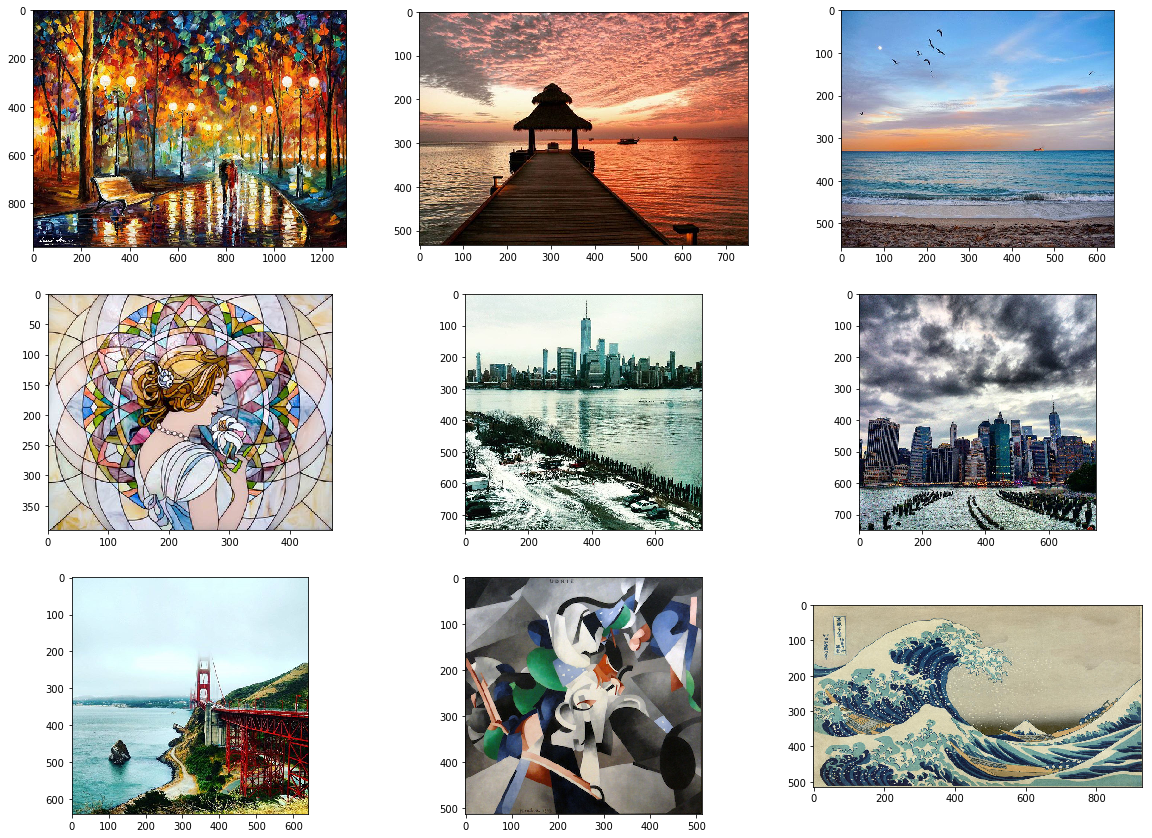

In [5]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# function to display list of images
def display_images(image_paths):
    plt.figure(figsize=(20,20))
    columns = 3
    for i, image in enumerate(image_paths):
        plt.subplot(len(image_paths) / columns + 1, columns, i + 1)
        plt.imshow(mpimg.imread(image))    
        
display_images(list(map(lambda img: directory + "/" + img, img_urls.keys())))
    

In [6]:
# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path, img_nrows, img_ncols):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [7]:
# util function to convert a tensor into a valid image
def deprocess_image(x, img_nrows, img_ncols):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Loss functions

The [VGG19](https://keras.io/applications/#vgg19) model is used to calculate the loss functions.

### Style loss
The gram matrix of activations of multiple layers of the CNN captures the correlation within these layers while losing the spatial information. This gram matrix for a set of low/high layers for both images is used to calculate the style loss.


In [8]:
# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [9]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 400 * 400 # constant of the order of the image size
    _style_loss = K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
    return(_style_loss) 


### Content loss
The content loss is calculated using the activation of one of the later layers of the CNN which captures more complex patterns.

In [ ]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    _content_loss = K.sum(K.square(combination - base))
    return _content_loss

### Variation Loss
This loss ensures the images are too pixelated by using the difference between adjacent pixels in the loss function.


In [ ]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    img_nrows = x.get_shape()[1]
    img_ncols = x.get_shape()[2]
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    _total_variation_loss = K.sum(K.pow(a + b, 1.25))
    return(_total_variation_loss)

In [ ]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):

    def __init__(self, f_outputs, img_nrows, img_ncols):
        self.loss_value = None
        self.grads_values = None
        self.f_outputs = f_outputs
        self.img_nrows = img_nrows
        self.img_ncols = img_ncols
        
    def eval_loss_and_grads(self, x):
        if K.image_data_format() == 'channels_first':
            x = x.reshape((1, 3, self.img_nrows, self.img_ncols))
        else:
            x = x.reshape((1, self.img_nrows, self.img_ncols, 3))
        outs = self.f_outputs([x])
        loss_value = outs[0]
        if len(outs[1:]) == 1:
            grad_values = outs[1].flatten().astype('float64')
        else:
            grad_values = np.array(outs[1:]).flatten().astype('float64')
        return loss_value, grad_values        

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = self.eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

I modified the code a little bit to make it easy to plug in any loss function for easier experimentation.

In [ ]:
def loss1(base_image, style_reference_image, combination_image):
    content_weight = 1.0
    style_weight = 1.0
    total_variation_weight = 1.0
    
    # combine the 3 images into a single Keras tensor
    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image], axis=0)
    
    # build the VGG19 network with our 3 images as input
    # the model will be loaded with pre-trained ImageNet weights
    model = vgg19.VGG19(input_tensor=input_tensor,
                        weights='imagenet', include_top=False)
    print('Model loaded.')
    
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


    # combine these loss functions into a single scalar
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features,
                                          combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


Here's the function that takes the two images and a loss function to perform the style transfer.

In [ ]:
def style_transfer(base_image_path, 
                   style_reference_image_path, 
                   result_prefix, 
                   loss_fn,
                   iterations=10):

    # dimensions of the generated picture.
    width, height = load_img(base_image_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)

    # get tensor representations of our images
    base_image = K.variable(preprocess_image(base_image_path, img_nrows, img_ncols))
    style_reference_image = K.variable(preprocess_image(style_reference_image_path, img_nrows, img_ncols))

    # this will contain our generated image
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1, img_nrows, img_ncols, 3))


    loss = loss_fn(base_image, style_reference_image, combination_image)
    
    # get the gradients of the generated image wrt the loss
    grads = K.gradients(loss, combination_image)

    outputs = [loss]
    if isinstance(grads, (list, tuple)):
        outputs += grads
    else:
        outputs.append(grads)

    f_outputs = K.function([combination_image], outputs)

    evaluator = Evaluator(f_outputs, img_nrows, img_ncols)

    # run scipy-based optimization (L-BFGS) over the pixels of the generated image
    # so as to minimize the neural style loss
    x = preprocess_image(base_image_path, img_nrows, img_ncols)

    for i in range(iterations):
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                         fprime=evaluator.grads, maxfun=20)
        print('Iteration ' + str(i) + ' loss value:', min_val)
        # save current generated image
        img = deprocess_image(x.copy(), img_nrows, img_ncols)
        # save every 10 images and the last one    
        if (i % 10 == 0) or (i == iterations - 1):
            fname = result_prefix + '_at_iteration_%d.png' % i
            save_img(fname, img)

Here I am finally running the functions above to see if everything is working as expected. 

In [ ]:
# Running an image with a style
iterations = 5
input_name = "nyc"
style = "wave"

result_prefix = "output/" + input_name + "_" + style
print("Input: " + input_name + "; Style: " + style)
style_transfer("images/" + input_name + ".jpg", 
               "images/" + style + ".jpg", 
               result_prefix, 
               loss1,
               iterations)

# Display each output iteration for a style        
display_images([(result_prefix + "_at_iteration_" + str(i) + ".png") for i in range(iterations)])

Looks like there is no issue losing content but the neural net is not able to capture style as much as I want it to. Below is an identical loss function from before with more weightage given to the style.


In [ ]:
def loss2(base_image, style_reference_image, combination_image):
    content_weight = 1.0
    style_weight = 3.0
    total_variation_weight = 1.0
    
    # combine the 3 images into a single Keras tensor
    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image], axis=0)
    
    # build the VGG19 network with our 3 images as input
    # the model will be loaded with pre-trained ImageNet weights
    model = vgg19.VGG19(input_tensor=input_tensor,
                        weights='imagenet', include_top=False)
    print('Model loaded.')
    
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


    # combine these loss functions into a single scalar
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features,
                                          combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [ ]:
# Running an image with a style
iterations = 5
input_name = "nyc"
style = "wave"

result_prefix = "output/" + input_name + "_" + style
print("Input: " + input_name + "; Style: " + style)
style_transfer("images/" + input_name + ".jpg", 
               "images/" + style + ".jpg", 
               result_prefix, 
               loss2,
               iterations)

# Display each output iteration for a style        
display_images([(result_prefix + "_at_iteration_" + str(i) + ".png") for i in range(iterations)])

In [10]:
# Running multiple images with multiple styles
iterations = 50

input_names = ['sf', 'nyc2', 'miami', 'maldives', 'nyc']
styles = ['mosaic', 'udnie', 'wave', 'afremo_rain']

In [ ]:
for input_name in input_names:
    for style in styles:
        result_prefix = "output/" + input_name + "_" + style
        print("Input: " + input_name + "; Style: " + style)
        style_transfer(f"images/{input_name}.jpg", 
                       f"images/{style}.jpg", 
                       result_prefix, 
                       loss1,
                       iterations)

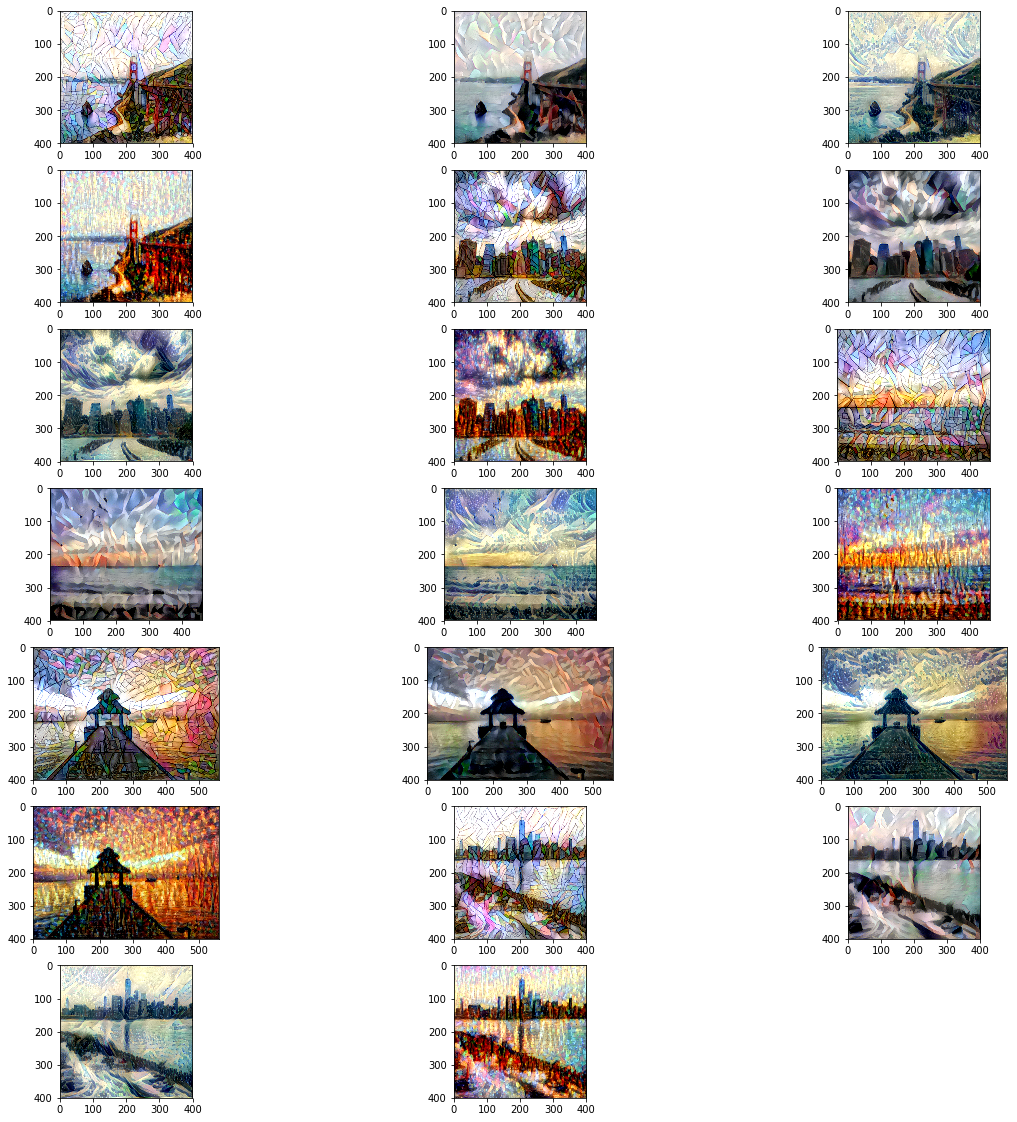

In [11]:
# Display just last output image for each style/input combination
display_images([("output/" + input_name + "_" + style + "_at_iteration_" + str(iterations - 1) + ".png") 
                    for input_name in input_names 
                    for style in styles])

## Reflections

- Based on my experiments, it is best to pick "content" images that will still look good despite some loss in detail and pick "style" images with distince colors/texture/style.
- Currently the neural network learns each style image each time - this can be improved by teaching a convnet a specific style over multiple cycles and then using that model to quickly copy over the style to fresh content images.
- The loss function is a clear place to tweak to try and produce better output images. The [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric) seems to produce better results based on [this](https://github.com/VinceMarron/style_transfer).
- Using other layers in the loss functions should also produce different results

## Resources
1. [Neural Style Transfer](https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb) (notebook)
2. [Neural Style Transfer: Creating Art with Deep Learning using tf.keras and eager execution](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398) (blog post)
3. [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) (paper)